# DiaBETO: a Diabetes intelligent assistant - Better Early Treatment Oracle

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Part 1: Load data into Colab

In [ ]:
# Cargar Diabetes2.csv
from google.colab import files
uploaded = files.upload()

Saving Diabetes2.csv to Diabetes2.csv


In [ ]:
# Import file and store it in a data frame
df = pd.read_csv('Diabetes2.csv')
df.dropna(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.CLASS = np.where(df.CLASS=='N', 0, 1)
df

,edad,genero,glucosa,IMC,CLASS
0,50,Femenino,4.9,24.0,0
1,26,Masculino,4.9,23.0,0
2,50,Femenino,4.9,24.0,0
3,50,Femenino,4.9,24.0,0
4,33,Masculino,4.9,21.0,0
...,...,...,...,...,...
995,71,Masculino,7.0,30.0,1
996,31,Masculino,12.3,37.2,1
997,30,Masculino,6.7,27.4,1
998,38,Masculino,6.7,40.5,1


# Part 2: Format data and split it into numpy arrays

In [ ]:
def gender_to_categorical(gen):
  enc = OneHotEncoder(sparse=False)
  WD = enc.fit_transform(gen)
  print("== categories:", enc.categories_, "==")
  return WD, [item for sublist in enc.categories_ for item in sublist]

== categories: [array(['Femenino', 'Masculino'], dtype=object)] ==
Input values X with shape (1000, 5). With values


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


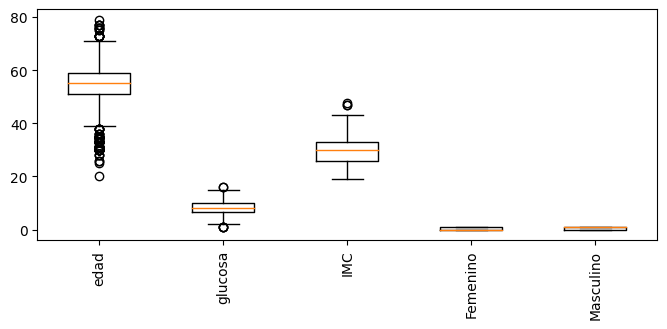

,0,1,2,3,4
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.528000,8.281160,29.578020,0.435000,0.565000
std,8.799241,2.534003,4.962388,0.496005,0.496005
min,20.000000,0.900000,19.000000,0.000000,0.000000
25%,51.000000,6.500000,26.000000,0.000000,0.000000
50%,55.000000,8.000000,30.000000,0.000000,1.000000
75%,59.000000,10.200000,33.000000,1.000000,1.000000
max,79.000000,16.000000,47.750000,1.000000,1.000000


In [ ]:
# Extract input features and convert them to a numpy array
labels = ['edad', 'glucosa', 'IMC' ]
X = df[labels].to_numpy()
WD, categories = gender_to_categorical(df[['genero']])
X = np.concatenate((X, WD), axis=1)

print(f"Input values X with shape {X.shape}. With values")

plt.figure(figsize=(8, 3))
plt.boxplot(X)
plt.xticks(range(1, 6), labels + categories, rotation=90)
plt.show()

pd.DataFrame(X).describe()

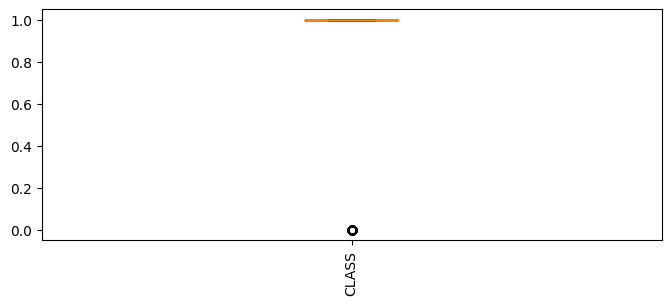

,0
count,1000.0000
mean,0.8980
std,0.3028
min,0.0000
25%,1.0000
50%,1.0000
75%,1.0000
max,1.0000


In [ ]:
# Extract output features and convert them to a numpy array
Y = df[['CLASS']].to_numpy()

plt.figure(figsize=(8, 3))
plt.boxplot(Y)
plt.xticks(range(1, 2), ['CLASS'], rotation=90)
plt.show()

pd.DataFrame(Y).describe()

In [ ]:
# Split data into train+val and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(900, 5)
(900, 1)
(100, 5)
(100, 1)


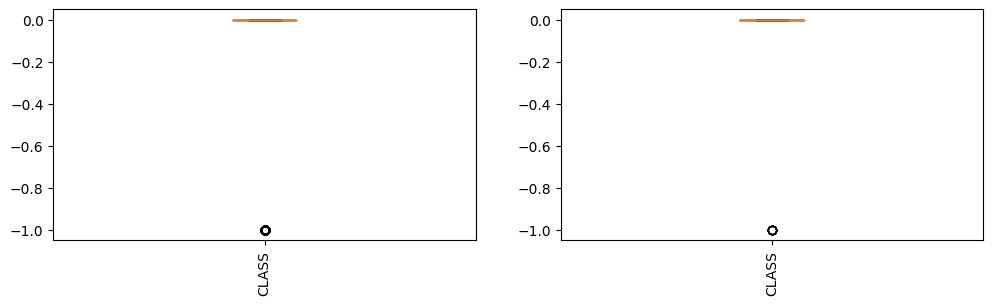

,0
count,900.000000
mean,-0.105556
std,0.307439
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.000000


In [ ]:
# Normalize (zero-center) and standardize (scale) output data
scalerY = RobustScaler()
y_train = scalerY.fit_transform(y_train)
y_test = scalerY.transform(y_test)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.boxplot(y_train)
plt.xticks(range(1, 2), ['CLASS'], rotation=90)
plt.subplot(1, 2, 2)
plt.boxplot(y_test)
plt.xticks(range(1, 2), ['CLASS'], rotation=90)
plt.show()

pd.DataFrame(y_train).describe()

# Part 3: Create DNN model and train it

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

# 3.1 Auto tuning of hyperparams: number of layers, number of units, and optimizer

In [ ]:
def model_builder(hp):
  ''' Define a auxiliar function to create DNN models with varying
      hyperparameters.
  '''
  model = Sequential()
  model.add(InputLayer(input_shape=x_train.shape[1:], name='INPUT'))

  # Choose optimal number of layers between 2 and 8
  for i in range(hp.Int('num_layers', 2, 8)):
    # Tune the number of units in the each dense layer
    hp_units = hp.Int('units_'+str(i), min_value=64, max_value=1024, step=64)
    model.add(Dense(units=hp_units, activation='tanh'))
  # Add output layer
  model.add(Dense(units=y_train.shape[1], name='OUTPUT', activation='sigmoid'))

  # Choose best optimizer
  model.compile(optimizer=hp.Choice('optimizer', values=['sgd', 'adam', 'adagrad', 'adadelta']), loss=tf.keras.losses.BinaryCrossentropy(), 
                metrics=['accuracy', tf.keras.metrics.Recall(),
     tf.keras.metrics.Precision()])
  
  return model

In [ ]:
# Create a tuner and show the search space
tuner = RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=64)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 8, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam', 'adagrad', 'adadelta'], 'ordered': False}


In [ ]:
# Make an initial quick exploration of the hyperparam space
tuner.search(x_train, y_train, epochs=10, validation_split=0.1)

Trial 64 Complete [00h 00m 07s]
val_loss: -26.759733200073242

Best val_loss So Far: -31.23483657836914
Total elapsed time: 00h 07m 49s


In [ ]:
# Get the top model
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 704)               4224      
                                                                 
 dense_1 (Dense)             (None, 384)               270720    
                                                                 
 dense_2 (Dense)             (None, 896)               344960    
                                                                 
 dense_3 (Dense)             (None, 384)               344448    
                                                                 
 dense_4 (Dense)             (None, 448)               172480    
                                                                 
 dense_5 (Dense)             (None, 128)               57472     
                                                                 
 dense_6 (Dense)             (None, 320)               4

In [ ]:
# Create a new model using the best hyperparams
DNN = model_builder(tuner.get_best_hyperparameters()[0])
DNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 704)               4224      
                                                                 
 dense_9 (Dense)             (None, 384)               270720    
                                                                 
 dense_10 (Dense)            (None, 896)               344960    
                                                                 
 dense_11 (Dense)            (None, 384)               344448    
                                                                 
 dense_12 (Dense)            (None, 448)               172480    
                                                                 
 dense_13 (Dense)            (None, 128)               57472     
                                                                 
 dense_14 (Dense)            (None, 320)              

In [ ]:
# Full training of best model
H = DNN.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_split=0.1)

Epoch 1/100
13/13 [==============================] - 4s 34ms/step - loss: -2.5653 - accuracy: 0.8914 - recall_1: 0.0118 - precision_1: 0.2500 - val_loss: -4.9374 - val_accuracy: 0.8889 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 0s 11ms/step - loss: -5.4039 - accuracy: 0.8951 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: -6.4652 - val_accuracy: 0.8889 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: -6.7887 - accuracy: 0.8951 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: -8.0042 - val_accuracy: 0.8889 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: -8.1835 - accuracy: 0.8951 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: -9.4894 - val_accuracy: 0.8889 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 5/

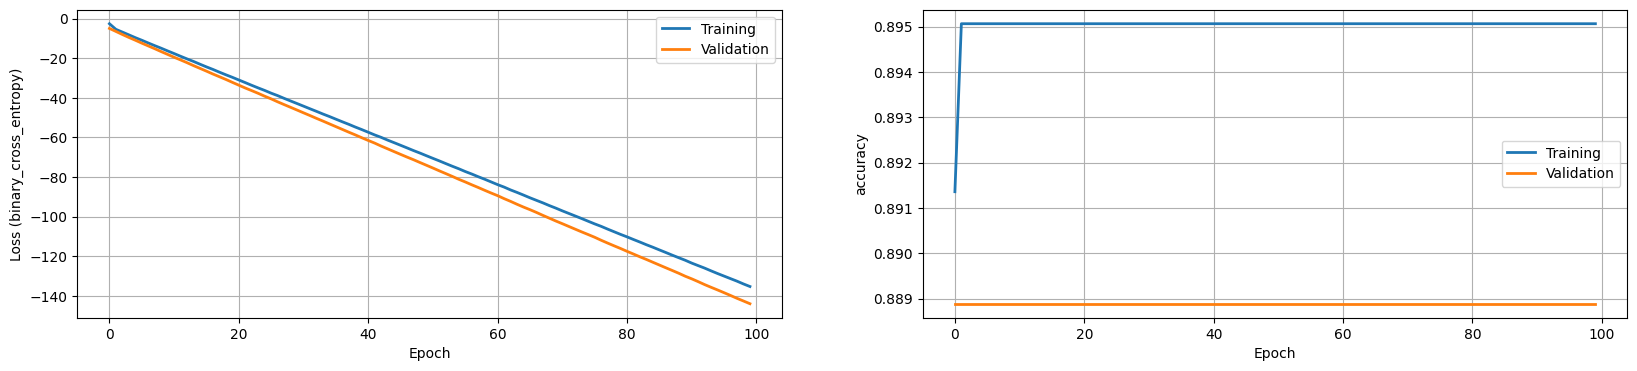

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_cross_entropy)')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(DNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid()
plt.show()

In [ ]:
# Compute test loss
loss_test = DNN.evaluate(x=x_test, y=y_test, verbose=False)
print("Test loss and accuracy:", loss_test)

Test loss and accuracy: [-90.69092559814453, 0.9300000071525574, 0.0, 0.0]


In [ ]:
# Predict on test set
y_test_hat = DNN.predict(x=x_test)
error = np.mean( y_test != y_test_hat )
print(error)

4/4 [==============================] - 0s 4ms/step
0.07


# Part 4: save model to disk and load it back





In [ ]:
# Save model to disk, then delete it

DNN.save("DiaBETO.h5")

del DNN

In [ ]:
# Load model back into memory, and use it for prediction
from tensorflow.keras.models import load_model
DNN = load_model("DiaBETO.h5")

y_test_hat = DNN.predict(x=x_test)
print(y_test_hat.shape)

4/4 [==============================] - 0s 4ms/step
(100, 1)
